# Train a variational autoencoder to perform clustering on the MNIST data set.

---



With this exercises I'm trying to learn the basics of training an ANN with Keras.

I will define and train a VAE on the MNIST data set based on what I learned from the book "Deep Learning with Python" (available at https://livebook.manning.com/book/deep-learning-with-python-second-edition/deep-learning-with-python/).

Then I will perform clustering on the codings.

# Load some libraries and the MNIST data set

## Import libraries
Import the necessary libraries to run this notebook:

In [1]:
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

from sklearn.cluster import KMeans
import sklearn.metrics

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Load and prepare the MNIST data set

Load de MNIST data set form Keras:

In [2]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

Show the first image and some properties:

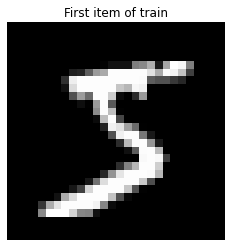

Label: 5
Shape: (28, 28)
Max/min: 255 0


In [3]:
plt.imshow(x_train[0].reshape(28,28))
plt.axis('off')
plt.set_cmap('gray')
plt.title("First item of train")
plt.show()
print("Label:", y_train[0])
print("Shape:", x_train[0].shape)
print("Max/min:", x_train[0].max(), x_train[0].min())

We need to adapt the input to fit the network: add one dimension and rescale the values so the range from 0 to 1.

In [4]:
x_train = np.expand_dims(x_train, -1).astype("float")/255
x_test = np.expand_dims(x_test, -1).astype("float")/255

We now have 60.000 images (and labels) to train the network and 10.000 to test it.

In [5]:
print("images shape:", x_train.shape)
print("images shape:", x_test.shape)
print("images shape:", y_train.shape)
print("images shape:", y_test.shape)

images shape: (60000, 28, 28, 1)
images shape: (10000, 28, 28, 1)
images shape: (60000,)
images shape: (10000,)


# K-means over raw MNIST images

To have some metrics to compare, lets apply k-means with 10 clusters over the raw images on the test data set, and show a contingency table of the true labels and the clustes.

We'll define a function to reuse later:

In [5]:
def kmeans_crosstab(x, y, k=10):
    kmeans = KMeans(n_clusters=k, n_init=30)
    kmeans.fit(x)

    confusion_matrix = sklearn.metrics.confusion_matrix(y, kmeans.labels_)
    heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
    heatmap.set(xlabel='clusters', ylabel='true labels')

    return kmeans

Shape before: (28, 28, 1)
Shape after: (784,)


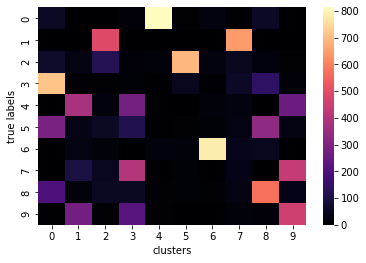

In [8]:
# Reshape the 10000 28x28x1 images to arrays of length 784
print("Shape before:", x_test[0].shape)
img_arrays = x_test.reshape(10000,-1)
print("Shape after:", img_arrays[0].shape)

kmeans_raw = kmeans_crosstab(img_arrays, y_test)

To measue the performance, we can define each cluster's "label" as the more freqüent true label in each one. Then, we can compute the accuracy with `sklearn.metrics`, as the number of coincidences between the true labels and the cluster's labels. Also, we can show the sum of squares error.

We'll define a function for later reuse:

In [19]:
def kmeans_performance(kmeans, true_labels):
    confusion_matrix = sklearn.metrics.confusion_matrix(true_labels, kmeans.labels_)
    clust_labels = confusion_matrix.argmax(0)[kmeans.labels_]

    acc = sklearn.metrics.accuracy_score(y_test, clust_labels)
    print("Acc: %0.4f" % acc)
    print("ARI: %0.4f" % sklearn.metrics.adjusted_rand_score(true_labels, kmeans.labels_))
    print("AMI: %0.4f" % sklearn.metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_))
    # X = points passed to Kmeans
    # print("Sil:", sklearn.metrics.silhouette_score(X, true_labels))

In [20]:
kmeans_performance(kmeans_raw, y_test)

Acc: 0.5938
ARI: 0.3819
AMI: 0.4994


# VAE model

Since the input for the VAE will be an image, we'll use a CNN for the encoder (and decoder).

We will base the CNN architecture on what we found in the exercise "MNIST_classifier_CNN2". But we will remove the activation on every single convolutional layer, and apply a ReLu function after the batch normalization layer. I've achieved better results this way, and the model train (slightly) faster.

## Define the encoder

We start by defining the encoder. It will take a 28x28 image as an input and otuput a two dimensional latent space that will define two normal distributions, described by their mean an variance (taken as log variance).

First we define a subclassed layer that will simplify the convolutional steps:

In [21]:
class ConvBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.conv1 = layers.Conv2D(filters, 3, padding="same")
        self.conv2 = layers.Conv2D(filters, 3, padding="same")
        self.strides = layers.Conv2D(filters, 3, strides=2, padding="same")
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.5)
        
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.strides(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return x

Now we can construct the encoder. We will construct it as a subclassed model, so that we'll be able to include a custom loss in it.

We'll compute the KL-divergence for the output and a normal distribution, so the model will try to minimize it during training.

In [22]:
class Encoder(keras.Model):
    def __init__(self, latent_dim = 2, name=None):
        super(Encoder, self).__init__(name=name)
        self.latent_dim = latent_dim
        self.conv_block_1 = ConvBlock(32)
        self.conv_block_2 = ConvBlock(64)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(16, activation="relu")
        self.z_mean = layers.Dense(self.latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(self.latent_dim, name="z_log_var")

    def call(self, encoder_inputs):
        x = self.conv_block_1(encoder_inputs)
        x = self.conv_block_2(x)
        x = self.flatten(x)
        x = self.dense(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        
        # Custom loss: KL-divergence
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        self.add_loss(kl_loss)
        # Add it also as a metric so it will show on the training output
        self.add_metric(kl_loss, name="kl_loss")
        
        return (z_mean, z_log_var)

And we instantiate it. We want the latent space to have 2 dimensions, so we set `latent_dim = 2`:

In [23]:
latent_dim = 2
encoder = Encoder(latent_dim = latent_dim, name="encoder")

## Define sampler and the decoder

We will need a bridge layer between the encoder and the decoder. We need to sample a point from the distribution generated by the encoder, so we can feed it to the decoder.

We'll define a subclassed layer that will take care of this:

In [24]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Like in the encoder, we'll define a subclassed layer that will take car of the "deconvolution" steps:

In [25]:
class DeconvBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.stridesT = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")
        self.convT1 = layers.Conv2DTranspose(filters, 3, padding="same")
        self.convT2 = layers.Conv2DTranspose(filters, 3, padding="same")
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.5)
        
    def call(self, inputs, training=False):
        x = self.stridesT(inputs)
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return x

And now we can define the decoder. It will take as an input a point from the latent space and output a reconstruted image.

We could construct it with the functional API, but maybe we'll want to add some custom logit later. It will be easier to do this way.

In [26]:
class Decoder(keras.Model):
    def __init__(self, name=None):
        super(Decoder, self).__init__(name=name)
        self.dense = keras.layers.Dense(7 * 7 * 64, activation="relu")
        self.reshape = layers.Reshape((7, 7, 64))
        self.deconv_block_1 = DeconvBlock(64)
        self.deconv_block_2 = DeconvBlock(32)
        self.outputs = layers.Conv2D(1, 3,
                                      activation="sigmoid",
                                      padding="same",
                                      name="decoder_outputs")
        
    def call(self, decoder_inputs):
        x = self.dense(decoder_inputs)
        x = self.reshape(x)
        x = self.deconv_block_1(x)
        x = self.deconv_block_2(x)
        decoder_outputs = self.outputs(x)
        
        return decoder_outputs

And we instantiate it:

In [27]:
decoder = Decoder(name="decoder")

## Define the VAE model

The complete model will consist of three steps, using the parts we defined before:
- Pass the inputs to the encoder and generate the latent distribution
- Sample a point from the latent distribution
- Pass the sample to the decoder and regenerate the original inputs


In [28]:
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_inputs")
z_mean, z_log_var = encoder(encoder_inputs)
z = Sampler(name="sampler") (z_mean, z_log_var)
decoder_outputs = decoder(z)

vae = keras.Model(encoder_inputs, decoder_outputs, name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Encoder)              ((None, 2),          161812      ['encoder_inputs[0][0]']         
                                 (None, 2))                                                       
                                                                                                  
 sampler (Sampler)              (None, 2)            0           ['encoder[0][0]',                
                                                                  'encoder[0][1]']                
                                                                                                

Before training the model, we need to specify a loss funciton.

We already added the `kl_loss` in the encoder model. But we need to specify a loss function for the output. We'll define a `reconstruction_loss`, that will compute the difference between the input image and the reconstructed one. The model will try to minimize this difference while trainint.

In [29]:
# Define the custom loss 
def reconstruction_loss(x, y):
    loss = tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(x, y),
            axis=(1, 2)
        )
    )
    return loss

Finally, we can compile the model. We'll use the Adam optimizer and specify the loss function for the output:

In [13]:
vae.compile(optimizer="adam", loss=reconstruction_loss)

## Train the model

We will use the `x_train` images for training the model and the `x_test` for validation. To aviod overfitting, we want to keep track of the validation loss and stop training if it stops improving after `patience` epochs. For this, we need to define our callbacks:

In [30]:
patience = 10

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
    )
]

And now we can train the model. We'll use `x_train` for the inputs and outputs, as we aim to reconstruct the original image. We don't need to specify any loss function since we added it to the model before.

In [19]:
epochs = 50

vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=128,
        validation_data=(x_test, x_test),
        callbacks = callbacks_list,
       )

Epoch 1/50
469/469 [==============================] - 10s 14ms/step - loss: 195.0708 - kl_loss: 3.0546 - val_loss: 182.6082 - val_kl_loss: 2.8261
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 167.1504 - kl_loss: 3.0973 - val_loss: 159.7377 - val_kl_loss: 3.1214
Epoch 3/50
469/469 [==============================] - 6s 13ms/step - loss: 162.5973 - kl_loss: 3.1636 - val_loss: 157.4265 - val_kl_loss: 3.0998
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 159.8254 - kl_loss: 3.1908 - val_loss: 155.7266 - val_kl_loss: 3.4688
Epoch 5/50
469/469 [==============================] - 6s 14ms/step - loss: 158.1861 - kl_loss: 3.2363 - val_loss: 152.6356 - val_kl_loss: 3.3870
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 157.0557 - kl_loss: 3.2724 - val_loss: 155.6703 - val_kl_loss: 3.8622
Epoch 7/50
469/469 [==============================] - 7s 14ms/step - loss: 155.9470 - kl_loss: 3.2959 - val_loss: 152.2413 - val_

## Save the model and the embeddings

We can't save the subclassed models the usual way with the `model.save()`, so for now we'll only save the weights. We can later construct the models the same way as before and then load the saved wheights with `model.load_weights`.

In [ ]:
# Save the model weights (if the file exists, it will rewrite it)
# encoder.save_weights("models/vae_encoder/weights")
# decoder.save_weights("models/vae_decoder/weights")
# vae.save_weights("models/vae_full/weights")

In [ ]:
# Load the model weights
# encoder.load_weights("models/vae_encoder/weights")
# decoder.load_weights("models/vae_decoder/weights")
# vae.load_weights("models/vae_full/weights")

We'll also generate the embeddings for the two data sets and save them on a file:

In [32]:
# Generate the embeddings
z_train, _ = encoder.predict(x_train)
z_test, _ = encoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [21]:
# Save them to a file for later
!mkdir embeddings
np.savetxt("embeddings/train.csv", z_train)
np.savetxt("embeddings/test.csv", z_test)

mkdir: cannot create directory ‘embeddings’: File exists


## Visualize the latent space

### Reconstructions grid
To take a look at the latent space generated, we can take points from a 30x30 grid on the latent space and regenerate the images and combine them in a single image:

In [37]:
n = 30
res = 28

img_latent_space = np.zeros((res * n, res * n))

grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(res, res)
        img_latent_space[i * res : (i + 1) * res,
                         j * res : (j + 1) * res] = digit

plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(img_latent_space, cmap="Greys_r")

### Histograms
We can visualize the embeddings for the data set as an histogram for each latent dimension. We'll assign a color to every label. We can see that each label follows a distribution similar to a normal (which is precisely what we are trying to do with a VAE). We'll plot only labels 0 to 4 to make a clearer histogram.

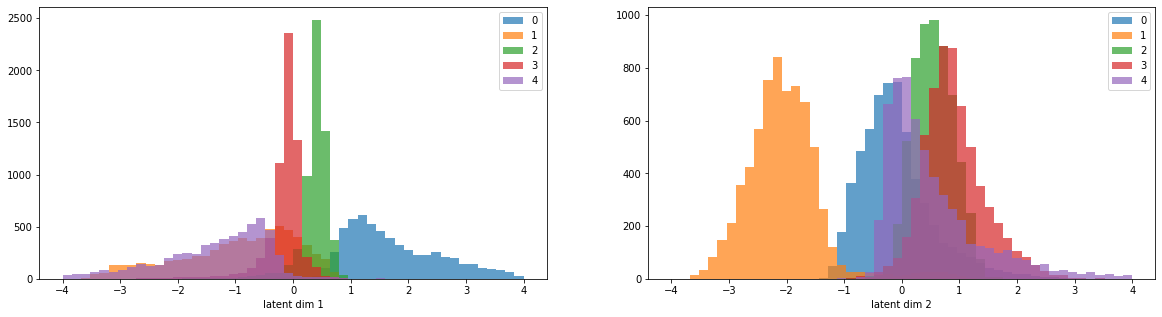

In [38]:
dic = {'z0': z_train[:,0],
       'z1': z_train[:,1],
        'lab': y_train,
       }
df = pd.DataFrame(dic)

plt.figure(figsize=(20,5))
plt0 = plt.subplot(1,2,1)
plt0.set_xlabel("latent dim 1")
plt1 = plt.subplot(1,2,2)
plt1.set_xlabel("latent dim 2")

for i in range(0,5):
    histdata = df.loc[df['lab'] == i]['z0']
    plt0.hist(histdata, range=(-4, 4), bins=50, alpha=0.7, label=i)
    histdata = df.loc[df['lab'] == i]['z1']
    plt1.hist(histdata, range=(-4, 4), bins=50, alpha=0.7, label=i)
plt0.legend()
plt1.legend()
plt.show()

### Scatterpots
Also, we can draw a scatterplot of the train data set embeddings and see how the labels are distributed.

We'll define a function so we can repeat the plot with different data:

In [16]:
def plot_latent_space(z, labels,
                      centroids = None,
                      figsize=(10,10),
                      legend_title = "Labels",
                      alpha=0.2
                      ):
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(z[:,0],
                        z[:,1],
                        label=labels,
                        c=labels,
                        cmap="tab10",
                        alpha=alpha,
                        linewidths=0,
                        )

    if centroids is not None:
        plt.scatter(centroids[:,0],
                    centroids[:,1],
                    c="black",
                    marker="x",
                    )

    leg = plt.legend(*scatter.legend_elements(), title=legend_title)
    # Make points in legend opaque
    for lh in leg.legendHandles: 
        # lh._legmarker.set_alpha(1) # old version of matplotlib
        lh.set_alpha(1)            # new version of matplotlib

    plt.show()

Now it's aeasy to plat the embeddings on the latent space. We'll color the points depending on their label.

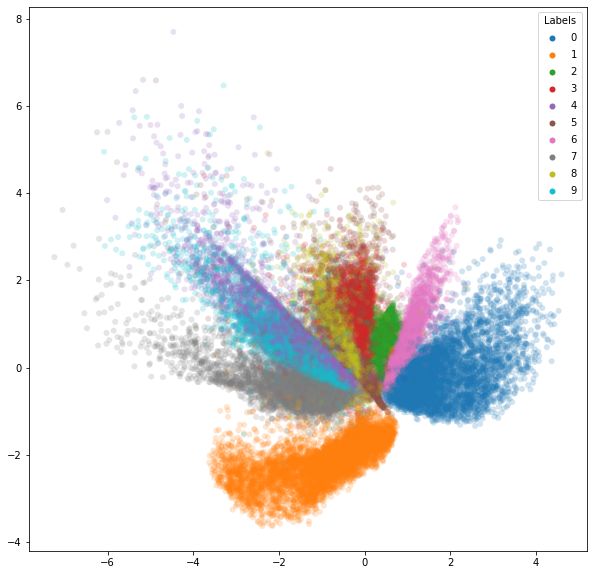

In [40]:
plot_latent_space(z_train, y_train)

The "zeros" and "ones" seem to get separated in two distinct groups. Also, the "twos", "sixes" and "sevens" seem to be well defined. But the rest of the labels are bunched toghether with no clear boundries.

## Compare an original image with its reconstruction

We can take a look at how the full model compresses and reconstructs an image. We'll define a function that takes a random sample from a data set, passes it through the encoder and decoder and shows the original and reconstructed image:

In [17]:
def compare(x):
    index = random.randint(0, x.shape[0])
    original = x[[index]]
    res = original.shape[1]
    figure = np.zeros((res, res*2))

    # Save the original image
    figure[0:res, 0:res] = original.reshape(res, res)

    # Encode it
    z, _ = encoder.predict(original, verbose=0)
    # Decode it (use the predicted mean, no need to sample from the distribution)
    decoded = decoder.predict(z, verbose=0)
    # Save the the reconstructed image
    reconstructed = decoded[0].reshape(res, res)
    figure[0:res, res:res*2] = reconstructed

    # Show original and reconstructed
    plt.figure()
    plt.axis("off")
    plt.imshow(figure, cmap="Greys_r")

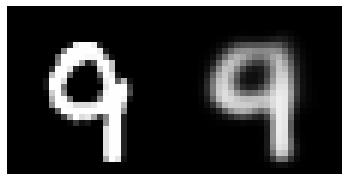

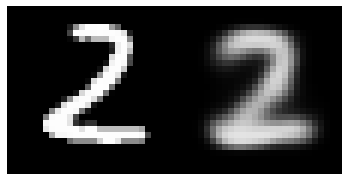

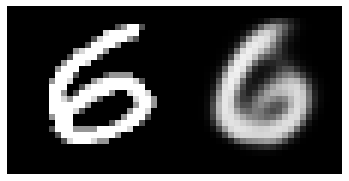

In [42]:
# Look at some examples
for _ in range(3):
    compare(x_test)

## Perform K-means clustering on embeddings

Our initial objective is to make a clustering model. Let's try clustering the embeddings with the k-means algorithm...

First, we'll try a range of `k` values and plot the SSE. We should expect a good result with `k=10` since we know we have 10 labels.

computing for k = 3
computing for k = 4
computing for k = 5
computing for k = 6
computing for k = 7
computing for k = 8
computing for k = 9
computing for k = 10
computing for k = 11
computing for k = 12
computing for k = 13
computing for k = 14
computing for k = 15


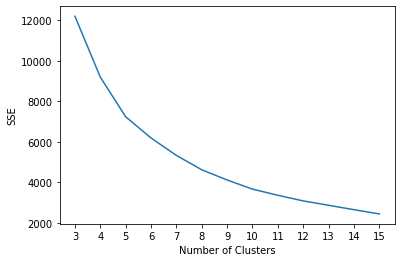

In [43]:
k_vals = np.arange(3, 16)
sse = []

for k in k_vals:
    print("computing for k =", k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(z_test)
    sse.append(kmeans.inertia_)
    
plt.plot(k_vals, sse)
plt.xticks(k_vals)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

It looks like we have an elbow on k=7. We will take k=10 anyway.

We'll repeat the contingency table and performance measures from the k-means study over the raw images. We'll use the test data set so we can compare the results.

Acc: 0.4984
ARI: 0.3133
AMI: 0.5300


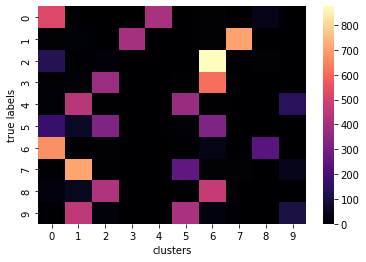

In [33]:
# kmeans_train = kmeans_crosstab(z_train, y_train)
# kmeans_performance(kmeans_train, y_train)
kmeans_test = kmeans_crosstab(z_test, y_test)
kmeans_performance(kmeans_test, y_test)

We see that some clusters relate to the original labels. For example, clustres 1 and 5 contain all the "zeros", but nothing else. The same happens for the "ones" and clusters 4 and 6. But the majority of the clusters and labels are mixted together.

In comparison with the clusters found on the raw images, we achieved a **worst** performance. We have not optimized for clustering quality, so it makes sense that it hasn't improved. We'll explore this results for a while and then fine-tune the model, retraining it with a clustering loss.

We can take the centroid of each group and reconstruct an image with the decoder:

1/1 [==============================] - 0s 14ms/step


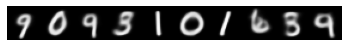

In [45]:
centroids = kmeans_test.cluster_centers_

res = 28
figure = np.zeros((res, res*centroids.shape[0]))

decoded_centroids = decoder.predict(centroids)

for i,x in enumerate(decoded_centroids):
    reconstructed_img = x.reshape(res, res)
    figure[0:res, i*res:(i+1)*res] = reconstructed_img

# Show original and reconstructed
plt.figure()
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

As we saw before, both clusters 1 and 5 generate a zero.

Maybe it will be clearer if we plot the centrois on top of the embeddings on the latent space:

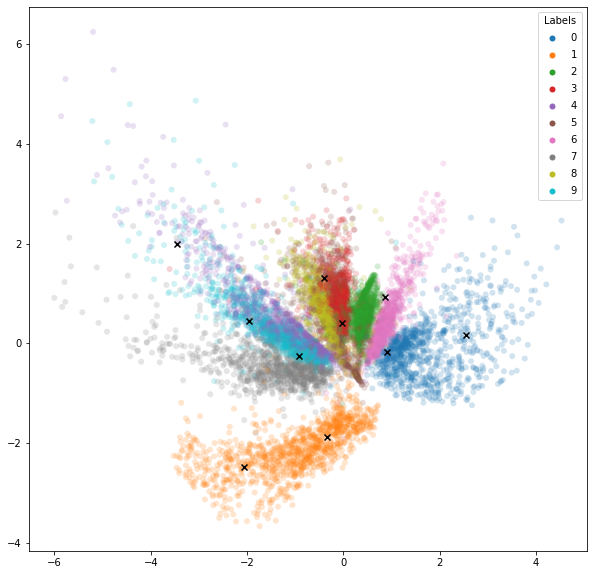

In [46]:
plot_latent_space(z_test, y_test, kmeans_test.cluster_centers_)

As we saw before, the "zeros" and "ones" both have two centroids on them. Also, the centroids near the origin seem to fall near boundries of different labels.

Let's repeat the plot but color the clusters instead of the labels:

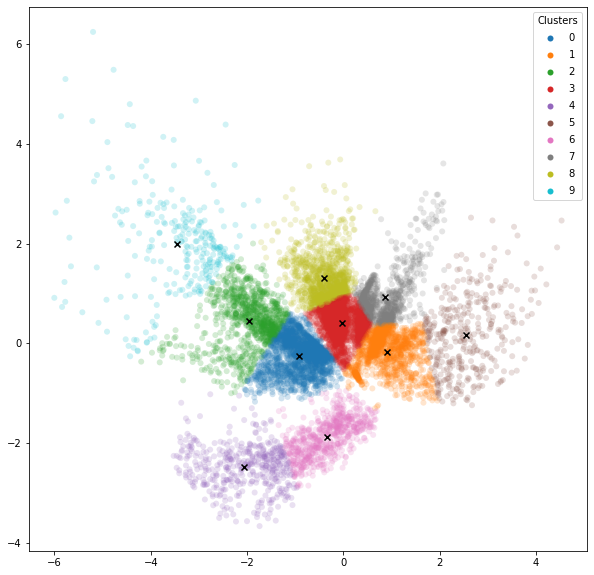

In [47]:
plot_latent_space(z_test, kmeans_test.labels_, kmeans_test.cluster_centers_, legend_title="Clusters")

We can see the clusters 4 and 6 contain all the "ones" and nothing else. Cluster 1 contains part of the "ones", but also a lot of "fives" and "sixes". In general, we don't see a good correlation between clusters and labels, specially near the origin where the labels are not well separated.

Just for reference, we can color the original clusters found on the raw images over the same scatterplot. We see that the cluster borders are much loosely defined, and also we don't see a observe correlation between clusters and labels.

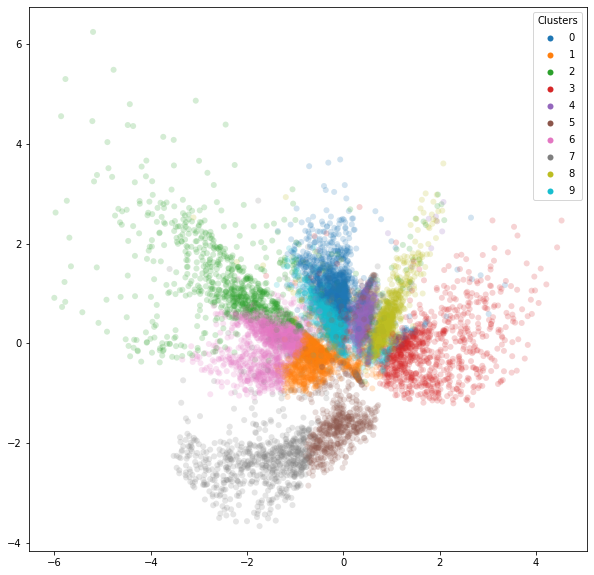

In [48]:
plot_latent_space(z_test, kmeans_raw.labels_, legend_title="Clusters")

# Add a classification layer

Before trying to add a clustering loss (and since I've been fighting with this for days), let's try doing something a little more simple. We'll reuse the pretrained encoder and decoder parts of the VAE and add a classification layer, that will take the sampled embeddings and try to predict the label correctly.

We will need to add a new loss for the classification layer (we will use the `categorical_crossentropy` packages with Keras). Also, we will have the provide the labels to the `model.train()` so it can compute the loss.

In [16]:
# First, encode the labels with one-hot encoding so we can pass them to the model as targets
onehot_train = to_categorical(y_train)
onehot_test = to_categorical(y_test)

## Construct the new model

In [17]:
# Construct the classifier model
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_inputs")
z_mean, z_log_var = encoder(encoder_inputs)
z = Sampler(name="sampler") (z_mean, z_log_var)
decoder_outputs = decoder(z)

class_outputs = layers.Dense(10, activation="softmax", name="classifier") (z)

class_vae = keras.Model(encoder_inputs, [decoder_outputs, class_outputs], name='class_vae')
class_vae.summary()

Model: "class_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Encoder)              ((None, 2),          161812      ['encoder_inputs[0][0]']         
                                 (None, 2))                                                       
                                                                                                  
 sampler (Sampler)              (None, 2)            0           ['encoder[0][0]',                
                                                                  'encoder[0][1]']                
                                                                                          

## Train the model and save the weights

In [55]:
# Compile the model. We specify a different loss for each output
class_vae.compile(optimizer="adam",
            loss={"decoder": reconstruction_loss,
                  "classifier": "categorical_crossentropy"
                 },
            )

In [ ]:
# And train it. Also, we spacify the targets for each output
epochs=50

class_vae.fit(x_train,
        {"decoder" : x_train,
         "classifier" : onehot_train,
        },
        epochs=epochs,
        batch_size=128,
        validation_data=(x_test, 
                         {"decoder" : x_test,
                          "classifier" : onehot_test,
                         }),
        callbacks = callbacks_list,
       )

Now we can save the weights as before

In [62]:
# Save the model weights (if the file exists, it will rewrite it)
# encoder.save_weights("models/classifier_encoder/weights")
# decoder.save_weights("models/classifier_decoder/weights")
# class_vae.save_weights("models/classifier_full/weights")

### Or load the previously saved weights

In [18]:
# Load the model weights
# encoder.load_weights("models/classifier_encoder/weights")
# decoder.load_weights("models/classifier_decoder/weights")
# class_vae.load_weights("models/classifier_full/weights")

## Plot the embeddings

Let's take a look at the new embeddings distribution

In [19]:
z_class_test, _ = encoder.predict(x_test)

313/313 [==============================] - 3s 2ms/step


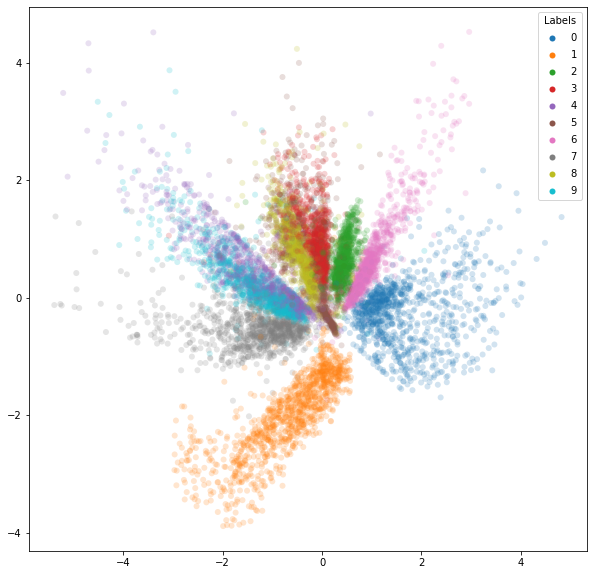

In [24]:
plot_latent_space(z_class_test, y_test)

It looks like the labels got more separated. It makes sense, since the classificaton loss we added applies some pressure to group the same labels more closely.

## Evaluate the model

Let's see how well we did with the classification:

In [25]:
_, preds = class_vae.predict(x_test)
preds = preds.argmax(1)
acc = sklearn.metrics.accuracy_score(y_test, preds)

print("Accuracy:", acc * 100)

313/313 [==============================] - 1s 2ms/step
Precision: 75.24


[Text(0.5, 15.0, 'predictions'), Text(33.0, 0.5, 'true labels')]

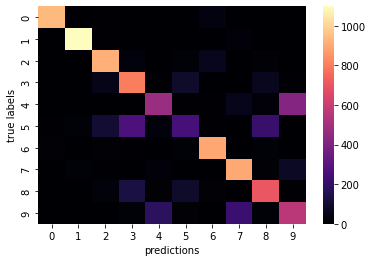

In [26]:
crosstab = pd.crosstab(y_test, preds)
heatmap = sns.heatmap(crosstab,  cmap='magma')
heatmap.set(xlabel='predictions', ylabel='true labels')

Not bad, but we did better with the CNN alone. But makes that sense it performes worse since we are compressing the data into a much smaller latent space, which also has another restriction: the points in the space need to be able to be reconstructed.

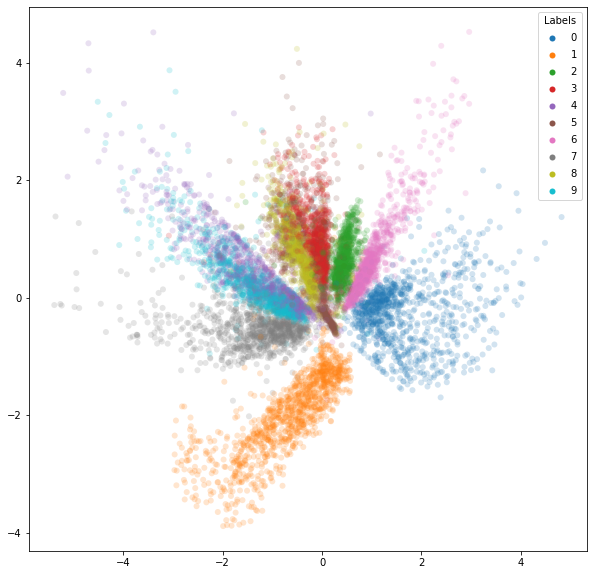

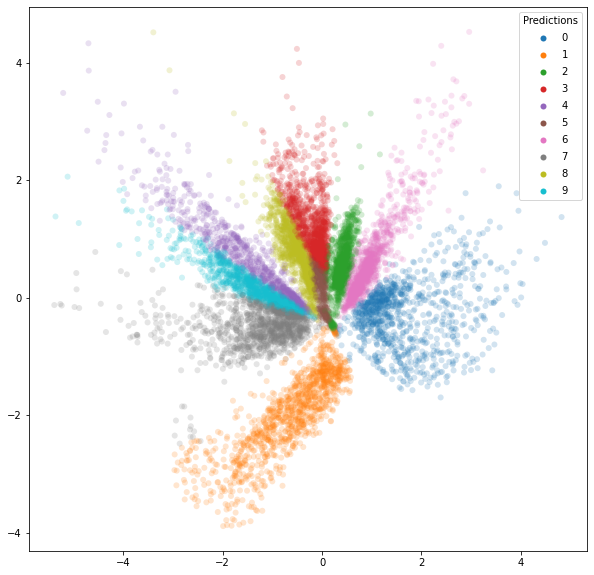

In [30]:
plot_latent_space(z_class_test, y_test)
plot_latent_space(z_class_test, preds, legend_title="Predictions")

It did pretty well, but still has problems separating the "sixes" and "nines", and the "threes", "fives", and "eights". It makes sense since they have similar shapes.

Is the model still able to compress and reconstruct the images?

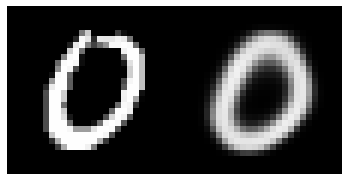

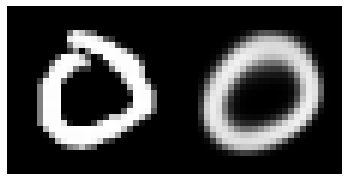

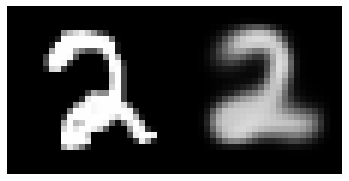

In [27]:
# Look at some examples
for _ in range(3):
    compare(x_test)

# Clustering VAE model

First, we reload the pretrained VAE weights as they where before we attached the classification layer.

In [18]:
# Reload pretrained VAE weights
vae.load_weights("models/vae_full/weights")

## Construc the new model

### Subclassed clustering layer with custom loss

First, we define a subclassed layer that will take care of the clustering part.

It will take the same samples that we feed to the decoder as input, compute the cluster assignments as a distribution that depends on the distance to each cluster, and outpupt that distribution.

Then, it computes an auxiliary distribution that depends on the clusters assigned with more confidence. Finally, it computes the loss function as the KL-divergence between the two distributions.

The cluster centroids are saved as the layer weights.

In [19]:
# Cluster assignment distribution and auxiliary distribution for computing the KL-divergence are computed
# as in https://github.com/Tony607/Keras_Deep_Clustering/blob/master/Keras-DEC.ipynb
# We should revise this as we don't obtain a good result this way...

class Clustering(layers.Layer):
    def __init__(self, n_clusters, name=None):
        super(Clustering, self).__init__(name=name)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        # Cluster centroids
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.n_clusters, input_dim),
                                        initializer='glorot_uniform',
                                       )
    
    def call(self, inputs, training=False):
        ## Cluster assignments
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        
        ## Clustering loss
        # Auxiliary distribution
        weight = q ** 2 / tf.reduce_sum(q, axis=0)
        p = tf.transpose(tf.transpose(weight) / tf.reduce_sum(weight, axis=1))
        
        clustering_loss = tf.reduce_sum(tf.keras.losses.kld(p, q))
        
        self.add_loss(clustering_loss)
        self.add_metric(clustering_loss, name="clust_loss")
        
        return q

### Construct the model

Now we can construct the model. It will output both the decoder outputs (reconstructed image) and the soft cluster assignments.

In [20]:
# Construct the VAE model
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_inputs")
z_mean, z_log_var = encoder(encoder_inputs)
z = Sampler(name="sampler") (z_mean, z_log_var)
decoder_outputs = decoder(z)

clust_outputs = Clustering(10, name="clustering") (z)

cvae = keras.Model(encoder_inputs, [decoder_outputs, clust_outputs], name='class_vae')
cvae.summary()

Model: "class_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Encoder)              ((None, 2),          161812      ['encoder_inputs[0][0]']         
                                 (None, 2))                                                       
                                                                                                  
 sampler (Sampler)              (None, 2)            0           ['encoder[1][0]',                
                                                                  'encoder[1][1]']                
                                                                                          

### Initialize the centroids with k-means

Before we start training, we need to initialize the centroids (otherwize, they will be set randomly). We will compute the centroids of the embeddings with the K-means algorithm:

In [21]:
z_train, _ = encoder.predict(x_train)
kmeans = KMeans(n_clusters=10, n_init=30)
kmeans.fit(z_train)

1875/1875 [==============================] - 5s 1ms/step


KMeans(n_clusters=10, n_init=30)

And update de clustering layer weights:

In [22]:
cvae.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Train the model and save the weights

Now we can compile and train our model. We will use the Adam optimizer with a slower learning rate (default = 0.001). We specify the loss function for the `decoder` output an nothing for the `clustering` output because the latter has its own loss configured in the subclassed Layer. But if we simply pass the `reconstruction_loss` without specifying, it will assume we want to use it for both outputs.

In [23]:
cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
             loss={"decoder":reconstruction_loss})

In [30]:
cvae.fit(x_train, x_train,
        epochs=30,
        batch_size=128,
        validation_data=(x_test, x_test),
        callbacks = callbacks_list,
       )

Epoch 1/30
469/469 [==============================] - 9s 16ms/step - loss: 165.2583 - decoder_loss: 141.0150 - kl_loss: 3.6574 - clust_loss: 20.5832 - val_loss: 159.2501 - val_decoder_loss: 136.8811 - val_kl_loss: 3.4975 - val_clust_loss: 18.6800
Epoch 2/30
469/469 [==============================] - 7s 15ms/step - loss: 164.3013 - decoder_loss: 141.0887 - kl_loss: 3.5753 - clust_loss: 19.6342 - val_loss: 158.4988 - val_decoder_loss: 136.8616 - val_kl_loss: 3.4535 - val_clust_loss: 17.9993
Epoch 3/30
469/469 [==============================] - 7s 15ms/step - loss: 163.4965 - decoder_loss: 141.0872 - kl_loss: 3.5282 - clust_loss: 18.8786 - val_loss: 157.9378 - val_decoder_loss: 136.9977 - val_kl_loss: 3.4095 - val_clust_loss: 17.3532
Epoch 4/30
469/469 [==============================] - 7s 14ms/step - loss: 162.9218 - decoder_loss: 141.2355 - kl_loss: 3.4917 - clust_loss: 18.1916 - val_loss: 157.4202 - val_decoder_loss: 137.1355 - val_kl_loss: 3.3820 - val_clust_loss: 16.7318
Epoch 5/30
4

In [36]:
# encoder.save_weights("models/clustering_encoder/weights")
# decoder.save_weights("models/clustering_decoder/weights")
# cvae.save_weights("models/clustering_full/weights")

### Or load the weights

In [37]:
# encoder.load_weights("models/clustering_encoder/weights")
# decoder.load_weights("models/clustering_decoder/weights")
# cvae.load_weights("models/clustering_full/weights")

## Plot the embeddings

Let's compute the new embeddings and plot them. We'll first color the points depending on the labels.

313/313 [==============================] - 0s 1ms/step


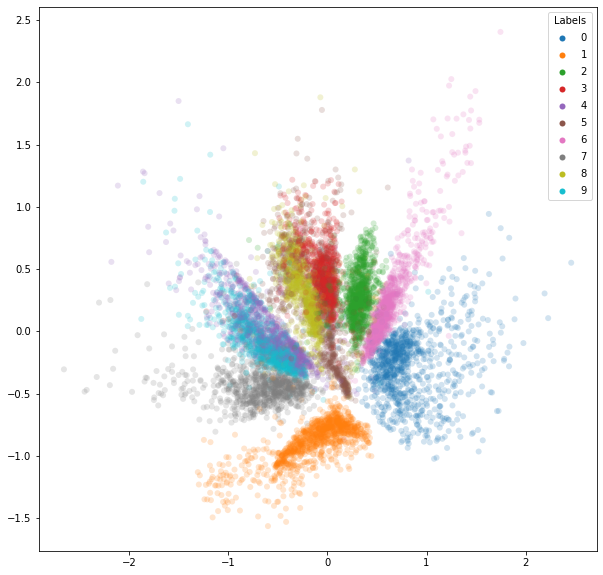

In [31]:
z_test, _ = encoder.predict(x_test)
plot_latent_space(z_test, y_test)

And then color them depending on the cluster assignments:

313/313 [==============================] - 1s 2ms/step


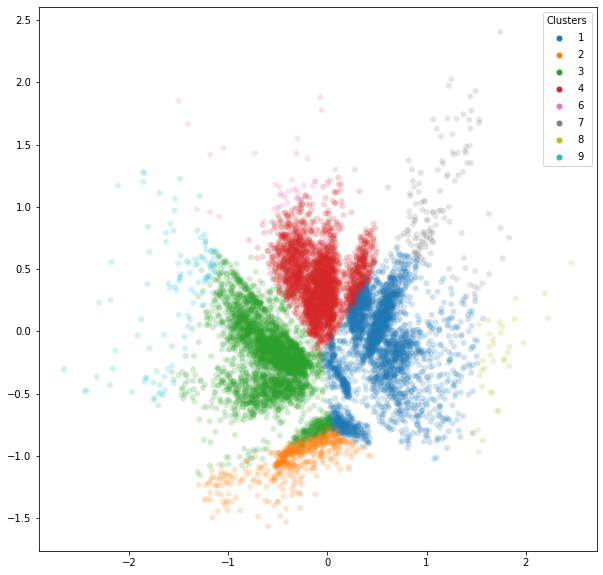

In [39]:
_, c_test = cvae.predict(x_test)
c_test = c_test.argmax(1)
plot_latent_space(z_test, c_test, legend_title="Clusters")

The clusters don't adjust at all to the labels... Also, we lost one cluster. If we train it for more epochs, it tends to leave only 3 or 4 clusters. Something must be wrong with our cluster assignment formula or with the loss function.

## Evaluate the model

Obviously, the performance is not good either:

[Text(0.5, 15.0, 'clusters'), Text(33.0, 0.5, 'true labels')]

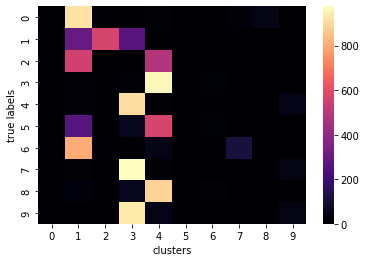

In [40]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, c_test)
heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='true labels')

# ToDo:

## Save full model
- Investigate how to save (and load) the full models as full models (not only weights).

## Improve clustering performance
- Revise soft assignment method
- Revise clustering loss
- Idea:
  - Set auxiliary distribution as non-trainable weights
  - Update them externally every n epochs via set_weights()
  - Compute the loss the same way
  
## Use better evaluation metrics